# Run ensemble Summa model on HPC

Structure for Unifying Multiple Modeling Alternative [(SUMMA)](https://ral.ucar.edu/projects/summa) is a hydrologic modeling approach that is built on a common set of conservation equations and a common numerical solver, which together constitute the structural core of the model. Different modeling approaches can then be implemented within the structural core, enabling a controlled and systematic analysis of alternative modeling options, and providing insight for future model development.

This notebook demonstrates how to harmonize different libraries and tools provided in the CyberGIS-Jupyter environment to run a 75-member ensemble SUMMA model with a High Performance Computer (HPC) resource. The SUMMA model instance and data used in this notebook were adapted from a part of the Clark et al., (2015) study, and explored the impact of different stomatal resistance parameterizations on total evapotranspiration (ET) in the Reynolds Mountain East catchment in southwestern Idaho.

Clark, M. P., B. Nijssen, J. Lundquist, D. Kavetski, D. Rupp, R. Woods, E. Gutmann, A. Wood, D. Gochis, R. Rasmussen, D. Tarboton, V. Mahat, G. Flerchinger, and D. Marks, 2015: A unified approach for process-based hydrologic modeling: Part 2. Model implementation and example applications. Water Resources Research, 51, doi: 10.1002/2015WR017200


# Notebook Outline
- [Retrieve Resources](#resources)
- [Unzip model instance package](#unzip)
- [Install SUMMA model](#install)
- [Use PySumma to build ensembles](#build)
- [Submit model](#submit)
- [Check model output](#check)
- [Plot the output](#plot)
    - [Leaf Area Index & ET](#LAI)
    - [stomatal resistance & ET](#stomatal)
- [Cleanup](#cleanup)

<a id='resources'></a>
## Retrieve a Summa model instance resource from HydroShare

This is the resource id of a HydroShare composite resource that contains a SUMMA model instance/. For more info on this resource please refer to https://www.hydroshare.org/resource/1f3f310af8364d2aa3e6a9459152a21c/)

In [1]:
resource_id = '1f3f310af8364d2aa3e6a9459152a21c'

We use HydroShare REST API Python client (hs_restclient) to retrieve the above resource onto the notebook server

In [2]:
import json
import os
from hs_restclient import HydroShare, HydroShareAuthBasic
auth = HydroShareAuthBasic("cybergis", "demo")
hs = HydroShare(auth=auth)
base_dir = os.path.abspath('/home/jovyan/work')
download_dir = os.path.join(base_dir, 'Downloads')
!mkdir -p {download_dir}
hs.getResource(resource_id, destination=download_dir, unzip=True)

<a id='unzip'></a>
## Unzip model instance package

Create a temporary local folder and unzip the summa instance

In [3]:
import os
#Unzip model file
model_folder_name = "SummaModel_ReynoldsAspenStand_StomatalResistance_sopron"
content_folder = os.path.join(download_dir ,"{}/{}/data/contents".format(resource_id, resource_id))
file_manger_rel_path = "settings/summa_fileManager_riparianAspenSimpleResistance.txt"
import tempfile
workspace_dir = os.path.join(base_dir, 'workspace')
!mkdir -p {workspace_dir}
unzip_dir = tempfile.mkdtemp(dir=workspace_dir)
!cd {content_folder} && unzip -o {model_folder_name}.zip -d {unzip_dir}
print("Unzipping Done")

Archive:  SummaModel_ReynoldsAspenStand_StomatalResistance_sopron.zip
   creating: /home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/
   creating: /home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/
   creating: /home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/
  inflating: /home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc  
  inflating: /home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson  
   creating: /home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/
  inflating: /home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFl

<a id='install'></a>
## "Install" SUMMA model on Jupyter server (fix broken path in summa file_manager)

By default, the file_manager file of the Summa instance does not contain local path. Need to use script to install it locally.

In [4]:
model_source_folder_path = os.path.join(unzip_dir, model_folder_name)
!cd {model_source_folder_path} && chmod +x ./installTestCases_local.sh
!cd {model_source_folder_path} && ./installTestCases_local.sh

TestCases installed


<a id='build'></a>
## Use PySumma to build ensembles

We create an empty "summa_zParamTrial_riparianAspen.nc" file so later we can do ensemble analysis on parameters

In [5]:
# Create a empty ParamTrial.nc file (required by parameter ensemble)
import netCDF4 as nc
name = os.path.join(model_source_folder_path, 'settings/summa_zParamTrial_riparianAspen.nc')
print(name)
param_trial = nc.Dataset(name, "w", format="NETCDF3_CLASSIC")
param_trial.createDimension("hru", 1)
param_trial.close()

/home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/settings/summa_zParamTrial_riparianAspen.nc


Build the ensemble cases: here we create a combination of different stomResist types, rootDistExp values and summerLAI values with help from PySumma. The total ensemble number is 75. We then save the 75 cases into a json file named "summa_options.json"

In [6]:
import numpy as np
import json
from pysumma import ensemble

def safe_arange(start, stop, step):
    a = np.arange(start, stop, step)
    result =[]
    for i in a:
        par = round(i, 10)
        result = np.append(result, par)
    return result

# create ensemble
# different parameterizations
decision_options = {
    "stomResist": ["BallBerry", "Jarvis", "simpleResistance"]
}
# different parameters
param_options = {
   'rootDistExp': safe_arange(0.01, 1.00, 0.20),
   'summerLAI': safe_arange(0.01, 10.00, 2.00)
}

config = ensemble.total_product(dec_conf=decision_options, param_conf=param_options)

# save ensemble info to json file
with open(os.path.join(model_source_folder_path, 'summa_options.json'), 'w') as outfile:
    json.dump(config, outfile)

# check ensemble parameters    
print("Number of ensemble runs: {}".format(len(config)))
print(json.dumps(config, indent=4, sort_keys=True)[:800])
print("...")

Number of ensemble runs: 75
{
    "++BallBerry++rootDistExp=0.01++summerLAI=0.01++": {
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {
            "rootDistExp": 0.01,
            "summerLAI": 0.01
        }
    },
    "++BallBerry++rootDistExp=0.01++summerLAI=2.01++": {
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {
            "rootDistExp": 0.01,
            "summerLAI": 2.01
        }
    },
    "++BallBerry++rootDistExp=0.01++summerLAI=4.01++": {
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {
            "rootDistExp": 0.01,
            "summerLAI": 4.01
        }
    },
    "++BallBerry++rootDistExp=0.01++summerLAI=6.01++": {
        "decisions": {
            "stomRe
...


<a id='submit'></a>
## Submit model to Virtual Roger HPC using CyberGIS-Jupyter tool

We use cybergis lib to submit the model to HPC as a job

In [7]:
from cybergis import summaUI

s = summaUI(model_source_folder_path, file_manger_rel_path, 
            workspace_dir)

Walltime (hour) is the maximum duration of time the job is allowed to run on the HPC before it gets killed.
Nodes indicate the number of CPU cores will be allocated for this job. CyberGIS lib will run the job over the assigned CPUs in parallel. If you select 16 nodes, then each node will run about 4-5 cases out of the 75-member ensemble

In [8]:
s.runSumma()

2020-07-13 18:18:14,146 [MainThread  ] [INFO ]  SSH logged into keeling.earth.illinois.edu as user cigi-gisolve
2020-07-13 18:18:14,160 [MainThread  ] [INFO ]  Uploading /home/jovyan/work/workspace/Summa_1594664292_4ed04a08 to /data/keeling/a/cigi-gisolve
2020-07-13 18:18:18,111 [MainThread  ] [INFO ]  Submitting Job summa.sbatch to queue
2020-07-13 18:18:18,523 [MainThread  ] [INFO ]  Remote Job ID assigned: 3580980
2020-07-13 18:18:22,053 [MainThread  ] [INFO ]  R
2020-07-13 18:18:26,044 [MainThread  ] [INFO ]  R
2020-07-13 18:18:29,702 [MainThread  ] [INFO ]  R
2020-07-13 18:18:33,255 [MainThread  ] [INFO ]  R
2020-07-13 18:18:36,819 [MainThread  ] [INFO ]  R
2020-07-13 18:18:40,369 [MainThread  ] [INFO ]  R
2020-07-13 18:18:43,875 [MainThread  ] [INFO ]  R
2020-07-13 18:18:47,424 [MainThread  ] [INFO ]  R
2020-07-13 18:18:50,995 [MainThread  ] [INFO ]  Job completed: Summa_1594664292_4ed04a08; 3580980
2020-07-13 18:18:50,996 [MainThread  ] [INFO ]  Downloading /data/keeling/a/cigi-

<a id='check'></a>
## Check model output  -- NetCDF files

Once job finishes execution on HPC, cybergis lib will retrieve the results back to notebook server. Each ensemble member will create a separate nc file, so there are 75 nc files in this case.

In [9]:
# check output directory
job_dir = os.path.join(workspace_dir, "{}".format(s.job_local_id))
output_path = os.path.join(job_dir, "output")
# check SUMMA output file 
name_list = os.listdir(output_path)
full_list = [os.path.join(output_path,i) for i in name_list if i.endswith(".nc")]
sorted_list = sorted(full_list)

for f in sorted_list:
    print(f)
print("Number of NC files: {}".format(len(sorted_list)))

/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=0.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=2.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=4.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=6.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=8.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.21++summerLAI=0.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp

<a id='plot'></a>
## Plot time series for total evapotranspiration (total ET)

Here we define a functions that can read in a list of Summa output nc files, calculate Total evapotranspiration and plot it

In [10]:
%matplotlib inline
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
import numpy as np

def calc_total_et(et_output_df):
    # Total Evapotranspiration = Canopy Transpiration + Canopy Evaporation + Ground Evaporation
    # Change unit from kgm-2s-1 to mm/hr (mulpitle 3600)
    total_et_data = (et_output_df['scalarCanopyTranspiration'] + et_output_df['scalarCanopyEvaporation'] + et_output_df['scalarGroundEvaporation'])*3600
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2006-07-01":"2007-08-20"]
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    return total_et_by_hour

def plot_ET(nc_list):
    
    dataset_list = [calc_total_et(xr.open_dataset(nc)) for nc in nc_list]
    ET_Combine = pd.concat(dataset_list, axis=1)
    ET_Combine_Graph = ET_Combine.plot()
    # invert y axis
    ET_Combine_Graph.invert_yaxis()

    # add x, y label
    ET_Combine_Graph.set(xlabel='Time of day (hr)', ylabel='Total evapotranspiration (mm h-1) ')
    # show up the legend
    legend = []
    for nc in nc_list:
        legend.append(os.path.basename(nc))
    ET_Combine_Graph.legend(legend, loc='center left', bbox_to_anchor=(1.0, 0.5))
    jtplot.figsize(x=10, y=10)

<a id='LAI'></a>
### How do different  Leaf Area Index (summerLAI) values affect total ET?

Here we only plot the ET results for different summaLAI by setting stomResist to BallBerry and rootDistExp=0.21

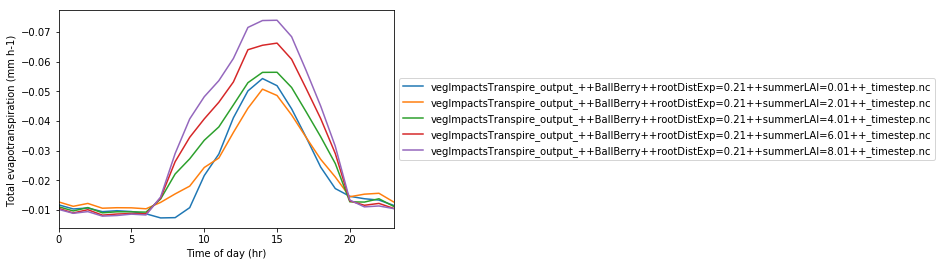

In [11]:
subset = [x for x in sorted_list if 'BallBerry++rootDistExp=0.21' in x]
plot_ET(subset)

<a id='stomatal'></a>
### How do different  stomatal resistance parameterizations affect total ET?

Here we only plot the ET results for different stomResist types by setting rootDistExp=0.21 and summerLAI to 4.01

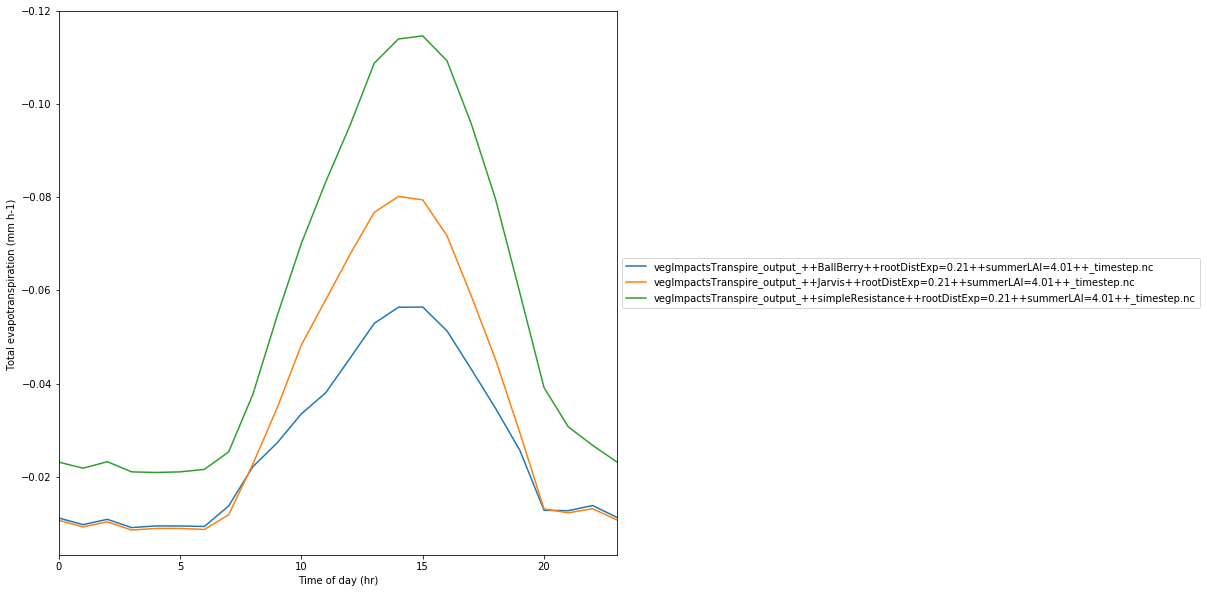

In [12]:
subset = [x for x in sorted_list if 'rootDistExp=0.21++summerLAI=4.01' in x]
plot_ET(subset)

<a id='cleanup'></a>
## Cleanup

This step is optional, which will remove all model outputs on notebook server

In [13]:
! rm -rvf {unzip_dir} {job_dir}

removed '/home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc'
removed directory '/home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData'
removed '/home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson'
removed '/home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFlux.nc'
removed directory '/home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData'
removed directory '/home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data'
removed '/home/jovyan/work/workspace/tmpjci_bhtz/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/installTestCases_local.sh'
removed directory '/home/jovyan/work/

removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.61++summerLAI=0.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++Jarvis++rootDistExp=0.21++summerLAI=0.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.81++summerLAI=0.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++simpleResistance++rootDistExp=0.81++summerLAI=2.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++simpleResistance++rootDistExp=0.01++summerLAI=0.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++simpleResistance++rootDistExp=0.61++summerLAI=4.01++_timestep.nc'
removed '/home/jovyan/work/workspa

removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=8.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++simpleResistance++rootDistExp=0.01++summerLAI=8.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++Jarvis++rootDistExp=0.81++summerLAI=8.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.41++summerLAI=8.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.61++summerLAI=8.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1594664292_4ed04a08/output/vegImpactsTranspire_output_++Jarvis++rootDistExp=0.01++summerLAI=8.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_15946642

# Done